In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime
from sklearn import neighbors
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import tree
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix,plot_confusion_matrix
from sklearn.model_selection import KFold, RepeatedKFold, GridSearchCV, RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, MinMaxScaler
from mlxtend.plotting import plot_decision_regions
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer


# Introduction

High energy consumption is often seen on the days with hotter temperatures. Working with two data sets a series of statistical and machine learning models were developed with the aim to help energy companies predict future usage and to help businesses plan when to conduct operations that have a high energy demand. One data set contained key weather indicators for Melbourne between January and August 2021 and the other contained energy price and demand figures for Victoria between January and August 2021. This report will detail the data science process that was followed to develop these models and discuss the methedology behind the models as well as their strenghts and weaknesses. 

# Data Cleaning
Our first step was to begin to explore the two data sets to build an understanding of the data. As well as some basic exploration we implemented some data wrangling and data aggregation methods. 

## Data Wrangling
Data cleaning and wrangling was done in OpenRefine, a software tool for data cleanup and transformation. 

Below are the wrangling steps used for each data set. 


**price_demand_data.csv**
- Split the settlementdate column into date and time column, give access date and time as seperate data features.
- Only one entry for for 1/09/2021 so removed this row from data set
- Checked for spelling with category name and date format
- Transform TOTALDEMAND column to int type and checked distribution for outliers
- Change date format to yyy-MM-dd for consistency and ordering 

**weather_data.csv**
- convert number columns to number type to make numeric operations possible in Python. 
- Wind speed column had data points with the value 'Calm'. Using domain knowledge we identified that calm means less than 1km/h windspeed. Calm was transformed to 0. 
- Rows with no min or max temperature were removed from data set - temperature was suspected to be highly correlated with demand and was highly variable. 
- Change date format to yyy-MM-dd for consistency and ordering 

## Data Aggregation
- In the price demand data set. Each day was grouped together with the maximum total demand value taken as well as the maximum price category for that day. 

## Data Exploration
To begin exploring data, excel was used to group data into pivot table to look for initial trends as well as creating scatterplots of features. 

With some understanding of the data the data frames were loaded into a Python Notebook for analysis.

In [2]:
# Load in cleaned sets as new DataFrames
price_demand_df = pd.read_csv('price-demand-data-csv.csv')
weather_data_df = pd.read_csv('weather-data-csv.csv')

display(price_demand_df.head(5))
display(weather_data_df.head(5))

,REGION,SETTLEMENTDATE,SETTLEMENTTIME,TOTALDEMAND,PRICECATEGORY
0,VIC1,2021-01-02,0:00,4402.64,LOW
1,VIC1,2021-01-02,0:30,4227.55,LOW
2,VIC1,2021-01-02,1:00,4069.91,LOW
3,VIC1,2021-01-02,1:30,3923.10,LOW
4,VIC1,2021-01-02,2:00,3785.74,LOW


,Date,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Evaporation (mm),Sunshine (hours),Direction of maximum wind gust,Speed of maximum wind gust (km/h),Time of maximum wind gust,9am Temperature (°C),...,9am cloud amount (oktas),9am wind direction,9am wind speed (km/h),9am MSL pressure (hPa),3pm Temperature (°C),3pm relative humidity (%),3pm cloud amount (oktas),3pm wind direction,3pm wind speed (km/h),3pm MSL pressure (hPa)
0,2021-01-01,15.6,29.9,0.0,2.8,9.3,NNE,31.0,13:14,19.2,...,6,N,2,1018.8,28.1,43,5.0,E,13,1015.3
1,2021-01-02,18.4,29.0,0.0,9.4,1.3,NNW,30.0,8:22,23.3,...,7,NNW,17,1013.3,28.7,38,7.0,SW,4,1008.5
2,2021-01-03,17.0,26.2,12.6,4.8,7.1,WSW,33.0,17:55,18.3,...,8,WSW,4,1007.7,23.5,59,4.0,SSW,2,1005.2
3,2021-01-04,16.0,18.6,2.6,3.8,0.0,SSE,41.0,16:03,16.2,...,8,SSE,11,1010.0,18.2,82,8.0,SSW,17,1011.0
4,2021-01-05,15.9,19.1,11.2,1.0,0.0,SSE,35.0,11:02,17.2,...,8,SSE,13,1012.5,18.2,82,8.0,SSE,19,1013.3


In [3]:
# Encode Pricecategory to ordinal numeical values. LOW < MEDIUM < HIGH < EXTREME - encoded to 0 < 1 < 2 < 3 
# Looked at OrdinalEncode but this was a quicker and easier method to implement. For data sets with more categories would need to look at different approach

price_demand_df['PRICECATEGORY'] = price_demand_df['PRICECATEGORY'].replace('LOW', 0)
price_demand_df['PRICECATEGORY'] = price_demand_df['PRICECATEGORY'].replace('MEDIUM', 1)
price_demand_df['PRICECATEGORY'] = price_demand_df['PRICECATEGORY'].replace('HIGH', 2)
price_demand_df['PRICECATEGORY'] = price_demand_df['PRICECATEGORY'].replace('EXTREME', 3)


# le = LabelEncoder()
# price_demand_df['PRICECATEGORY'] = le.fit_transform(price_demand_df['PRICECATEGORY'])

display(price_demand_df)

,REGION,SETTLEMENTDATE,SETTLEMENTTIME,TOTALDEMAND,PRICECATEGORY
0,VIC1,2021-01-02,0:00,4402.64,0
1,VIC1,2021-01-02,0:30,4227.55,0
2,VIC1,2021-01-02,1:00,4069.91,0
3,VIC1,2021-01-02,1:30,3923.10,0
4,VIC1,2021-01-02,2:00,3785.74,0
...,...,...,...,...,...
11611,VIC1,2021-08-31,21:30,5075.93,1
11612,VIC1,2021-08-31,22:00,4861.91,1
11613,VIC1,2021-08-31,22:30,4748.74,1
11614,VIC1,2021-08-31,23:00,4620.09,1


The TOTALDEMAND for each day was aggregated to get the max, min, sum and mean. The maximum PRICECATEGORY was also aggregated. These features were then merged to the weather dataset using the date as the key for merging. 

In [4]:
# get aggregate data for feature selection
demand_agg = price_demand_df.groupby('SETTLEMENTDATE') \
    ['TOTALDEMAND'].agg(['min','max','sum','mean']).round(2).reset_index().rename(columns={'max':'demand max', 'min':'demand min', 'sum':'demand sum', 'mean':'demand mean'})

demand_data_max = price_demand_df.groupby('SETTLEMENTDATE')[['TOTALDEMAND', 'PRICECATEGORY']].max().reset_index().rename(columns={'SETTLEMENTDATE':'Date', 'TOTALDEMAND' : 'demand max', 'PRICECATEGORY':'pricecategory max'})

# # Merge data sets
all_data = weather_data_df.merge(demand_data_max, how='inner', on='Date')



all_data.head(5)

,Date,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Evaporation (mm),Sunshine (hours),Direction of maximum wind gust,Speed of maximum wind gust (km/h),Time of maximum wind gust,9am Temperature (°C),...,9am wind speed (km/h),9am MSL pressure (hPa),3pm Temperature (°C),3pm relative humidity (%),3pm cloud amount (oktas),3pm wind direction,3pm wind speed (km/h),3pm MSL pressure (hPa),demand max,pricecategory max
0,2021-01-02,18.4,29.0,0.0,9.4,1.3,NNW,30.0,8:22,23.3,...,17,1013.3,28.7,38,7.0,SW,4,1008.5,4964.35,0
1,2021-01-03,17.0,26.2,12.6,4.8,7.1,WSW,33.0,17:55,18.3,...,4,1007.7,23.5,59,4.0,SSW,2,1005.2,4503.31,0
2,2021-01-04,16.0,18.6,2.6,3.8,0.0,SSE,41.0,16:03,16.2,...,11,1010.0,18.2,82,8.0,SSW,17,1011.0,4764.18,0
3,2021-01-05,15.9,19.1,11.2,1.0,0.0,SSE,35.0,11:02,17.2,...,13,1012.5,18.2,82,8.0,SSE,19,1013.3,4800.64,0
4,2021-01-06,13.7,19.2,1.2,1.0,3.2,S,35.0,14:56,15.2,...,11,1020.0,18.1,63,7.0,SSW,17,1020.0,4691.13,0


In [5]:
# Get all categorical data types. Drop date as we don't want to encode this. 
categorical_features = list(all_data.select_dtypes(include=['object']).drop(columns=['Date', 'Time of maximum wind gust']).columns)

display(categorical_features)

# # imputer missing values via imputation (use most frequent for categorical variables)
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
all_data[categorical_features] = imp.fit_transform(all_data[categorical_features])

encoded_all_data = pd.get_dummies(all_data, columns=categorical_features)

display(encoded_all_data)


['Direction of maximum wind gust', '9am wind direction', '3pm wind direction']

,Date,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Evaporation (mm),Sunshine (hours),Speed of maximum wind gust (km/h),Time of maximum wind gust,9am Temperature (°C),9am relative humidity (%),...,3pm wind direction_NNW,3pm wind direction_NW,3pm wind direction_S,3pm wind direction_SE,3pm wind direction_SSE,3pm wind direction_SSW,3pm wind direction_SW,3pm wind direction_W,3pm wind direction_WNW,3pm wind direction_WSW
0,2021-01-02,18.4,29.0,0.0,9.4,1.3,30.0,8:22,23.3,52,...,0,0,0,0,0,0,1,0,0,0
1,2021-01-03,17.0,26.2,12.6,4.8,7.1,33.0,17:55,18.3,100,...,0,0,0,0,0,1,0,0,0,0
2,2021-01-04,16.0,18.6,2.6,3.8,0.0,41.0,16:03,16.2,98,...,0,0,0,0,0,1,0,0,0,0
3,2021-01-05,15.9,19.1,11.2,1.0,0.0,35.0,11:02,17.2,96,...,0,0,0,0,1,0,0,0,0,0
4,2021-01-06,13.7,19.2,1.2,1.0,3.2,35.0,14:56,15.2,72,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,2021-08-27,4.6,13.6,0.0,1.2,3.8,15.0,12:18,7.7,88,...,0,0,0,0,1,0,0,0,0,0
237,2021-08-28,5.3,17.8,0.0,1.6,9.6,39.0,13:14,9.1,80,...,1,0,0,0,0,0,0,0,0,0
238,2021-08-29,9.1,16.2,0.6,6.4,4.3,33.0,1:50,10.6,79,...,0,0,1,0,0,0,0,0,0,0
239,2021-08-30,6.4,17.6,4.0,1.4,7.4,50.0,14:04,11.1,70,...,1,0,0,0,0,0,0,0,0,0


## Data Exploration


Looked at the variability of the temperature features to look for outliers and to help decide how to manage missing data points. Seeing the high variance we decided to throw out days that had missing temperature variables and impute any others. 

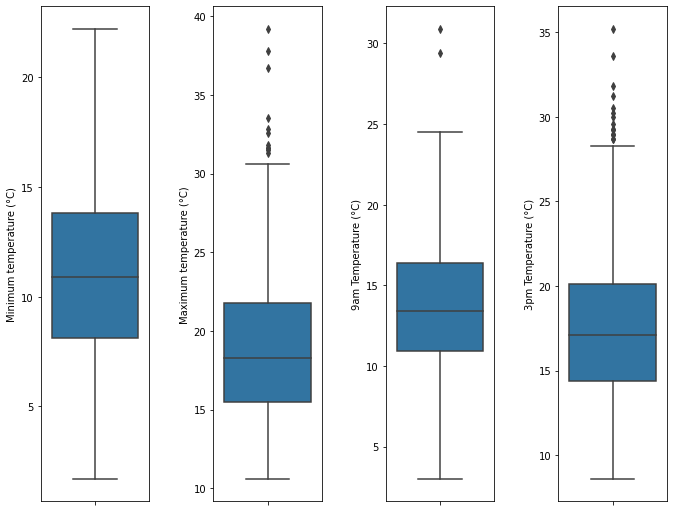

In [6]:
fig, axes = plt.subplots(1,4, figsize=(10,8))
fig.tight_layout(pad=3.0)

# Plots to visualise weather data 
sns.boxplot(data=all_data, y='Maximum temperature (°C)', ax=axes[1])
sns.boxplot(data=all_data, y='Minimum temperature (°C)', ax=axes[0])
sns.boxplot(data=all_data, y='9am Temperature (°C)', ax=axes[2])
sns.boxplot(data=all_data, y='3pm Temperature (°C)', ax=axes[3])

plt.show()


To further explore the data set we plotted the distribution of some key features. 

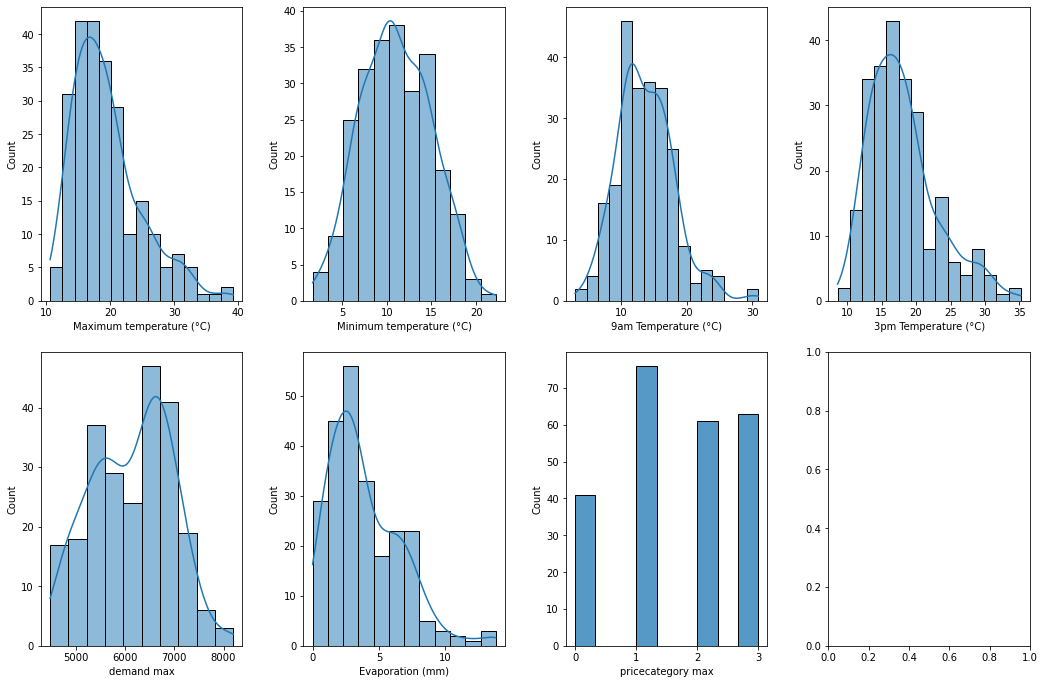

In [7]:
# Histograms of data and distribution

fig, axes = plt.subplots(2,4, figsize=(15,10))
fig.tight_layout(pad=3.0)

# Plots to visualise weather data 
sns.histplot(all_data['Maximum temperature (°C)'], kde=True, ax=axes[0,0])
sns.histplot(all_data['Minimum temperature (°C)'], kde=True, ax=axes[0,1])
sns.histplot(all_data['9am Temperature (°C)'], kde=True, ax=axes[0,2])
sns.histplot(all_data['3pm Temperature (°C)'], kde=True, ax=axes[0,3])

sns.histplot(all_data['demand max'], kde=True, ax=axes[1,0])
sns.histplot(all_data['Evaporation (mm)'], kde=True, ax=axes[1,1])
sns.histplot(all_data['pricecategory max'], ax=axes[1,2])

plt.show()

To begin looking at which statistical models to use we created a pairwise pearson correlation matrix and plotted this as a heatmap. This heatmap gave us information on which pairs of features showed signs of a relationship. We could begin to see which features showed signs of correlation total demand as well as price category. We are aware that correlation does not equal causation.

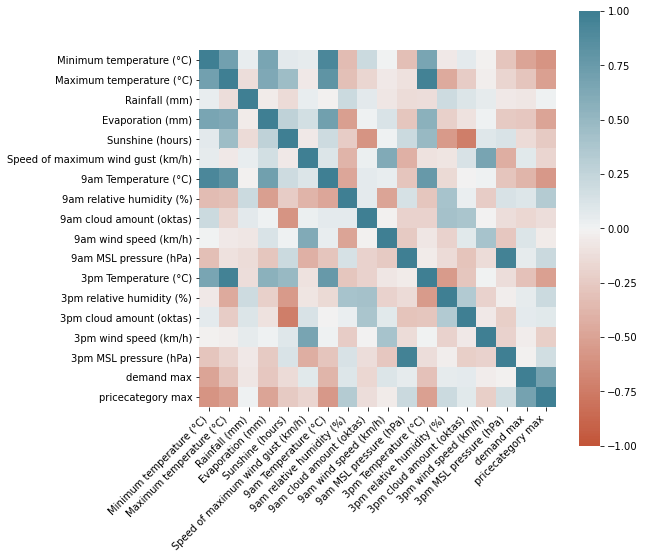

In [8]:
# Look for pairwise correlations

corr = all_data.corr()
plt.figure(figsize=(8,8))

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

Look at the top features that had positive and negative correlation with numbers close to -1 being more strongly negatively correlated and numbers closer to 1 being positively correlated.

In [9]:
# get top correlations for demand max
corr_demand_max = pd.DataFrame()

# Top 6 negative correlations
display(corr['demand max'].sort_values()[0:10])

# Top 6 postive correlations
display(corr['demand max'].sort_values(ascending=False)[0:10])


Minimum temperature (°C)   -0.488533
9am Temperature (°C)       -0.389363
3pm Temperature (°C)       -0.311364
Maximum temperature (°C)   -0.284417
Evaporation (mm)           -0.263630
9am cloud amount (oktas)   -0.158173
Sunshine (hours)           -0.141966
Rainfall (mm)              -0.076050
3pm wind speed (km/h)      -0.036011
3pm MSL pressure (hPa)     -0.009376
Name: demand max, dtype: float64

demand max                           1.000000
pricecategory max                    0.679884
9am wind speed (km/h)                0.110477
9am relative humidity (%)            0.105491
Speed of maximum wind gust (km/h)    0.081221
3pm cloud amount (oktas)             0.068816
3pm relative humidity (%)            0.060575
9am MSL pressure (hPa)               0.053409
3pm MSL pressure (hPa)              -0.009376
3pm wind speed (km/h)               -0.036011
Name: demand max, dtype: float64

Looking at the weather features, the negative corelation features are all more strongly correlated than the positive ones with the four temperature features having the highest correlaton. We will explore those further as stronger correlation indicates some relationship with maximum energy demand.

To further explore these variables we created scatter plots of each of the temperature features vs the maximum total demand. Each point is a day fromthe data set. We also created a regression line for each plot to visualise the correlation betweent the two features. 

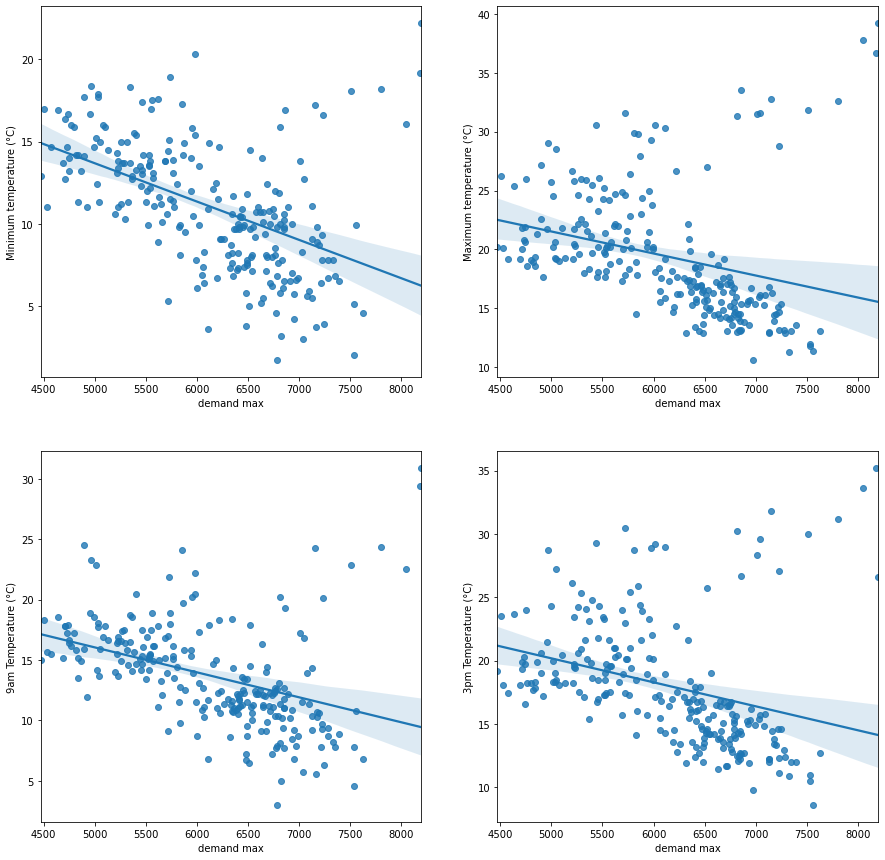

In [10]:
# Explore distribution of demand max vs other variables

fig, axes = plt.subplots(2, 2, figsize=(15,15))

# Plot the regression scatter plots for features with highest correlation with demand max

sns.regplot(data=all_data, x='demand max', y='Minimum temperature (°C)', ax=axes[0,0])
sns.regplot(data=all_data, x='demand max', y='Maximum temperature (°C)', ax=axes[0,1])
sns.regplot(data=all_data, x='demand max', y='9am Temperature (°C)', ax=axes[1,0])
sns.regplot(data=all_data, x='demand max', y='3pm Temperature (°C)', ax=axes[1,1])
plt.show()

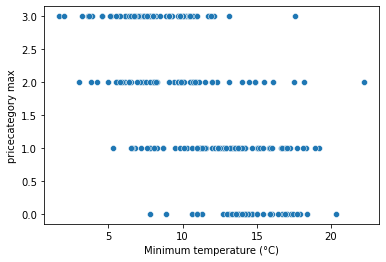

In [11]:
sns.scatterplot(x='Minimum temperature (°C)', y='pricecategory max', data=all_data)
plt.show()

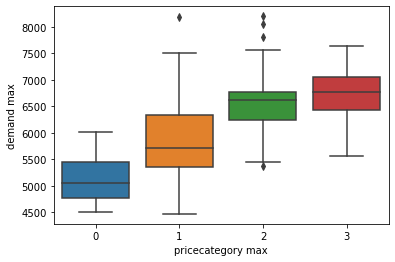

In [12]:
# Box plots of total demand for each price category
sns.boxplot(x='pricecategory max', y='demand max', data=all_data)
plt.show()

To look for signs of clustering we plotted the temperature variables and grouped them by their price category. There are signs of clustering but the cluters are not clearing defined from each other. 

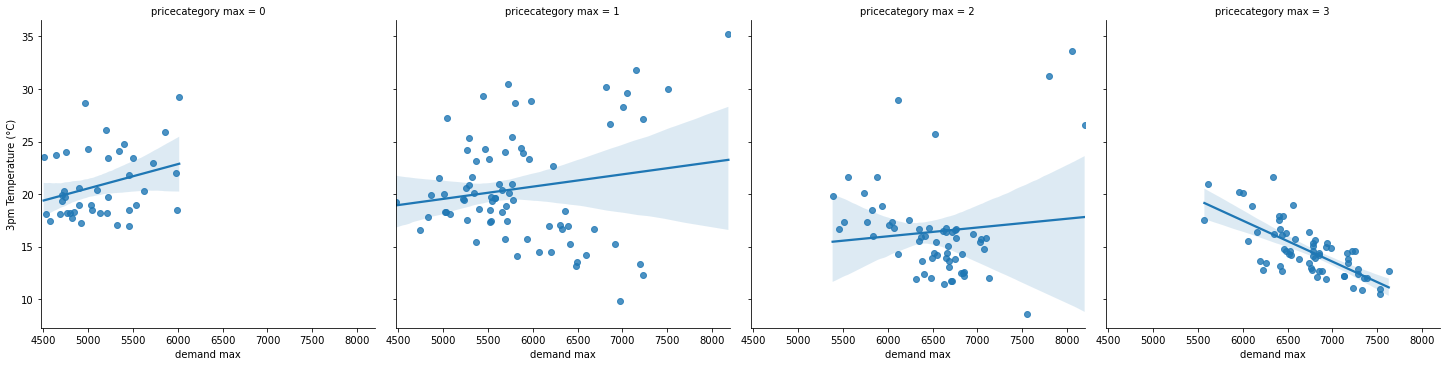

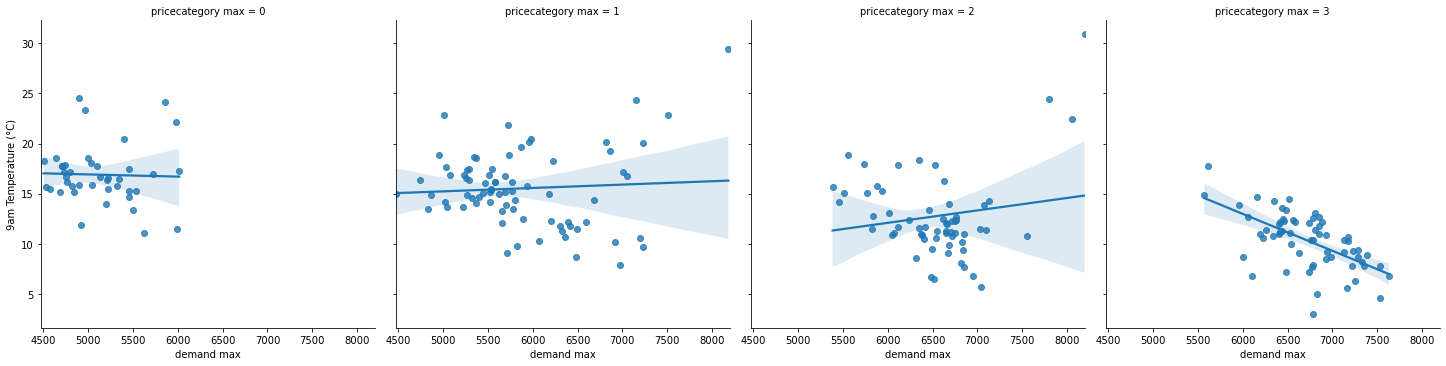

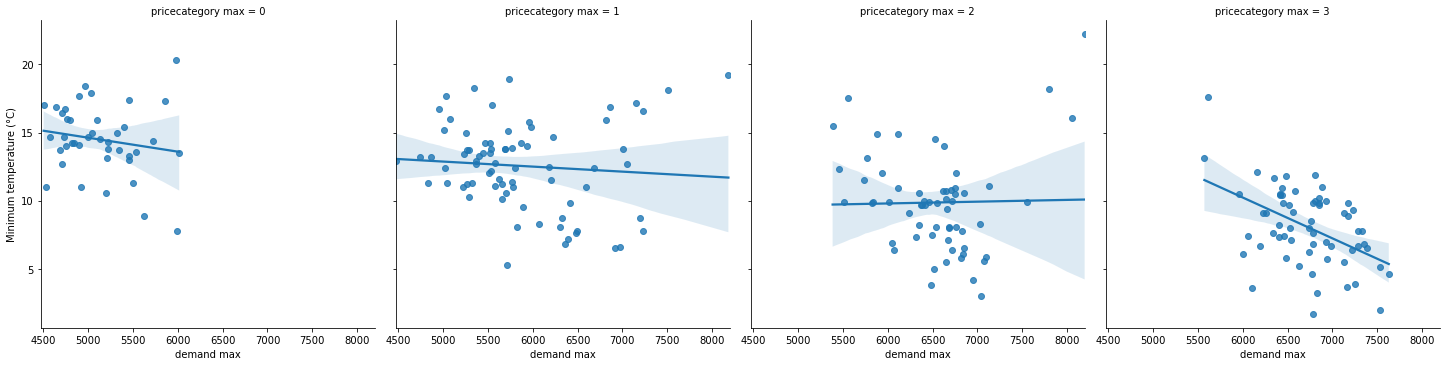

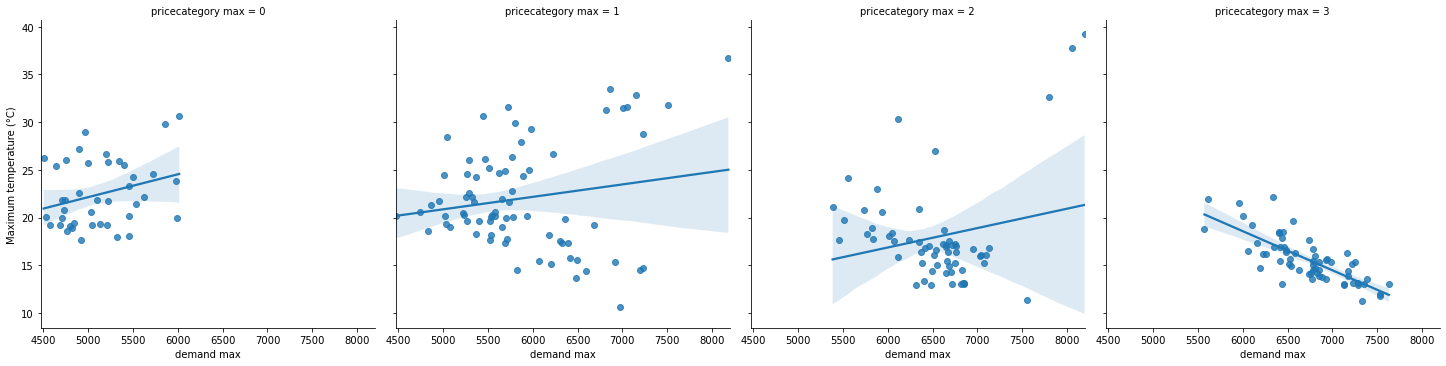

In [13]:
sns.lmplot(x='demand max', y='3pm Temperature (°C)', col='pricecategory max', fit_reg=True, data=all_data)
sns.lmplot(x='demand max', y='9am Temperature (°C)', col='pricecategory max', fit_reg=True, data=all_data)
sns.lmplot(x='demand max', y='Minimum temperature (°C)', col='pricecategory max', fit_reg=True, data=all_data)
sns.lmplot(x='demand max', y='Maximum temperature (°C)', col='pricecategory max', fit_reg=True, data=all_data)
plt.show()


# Predictive Modelling

## Linear Regression

In [14]:
# Remove nan values
all_data = all_data.dropna()
all_data.shape

(236, 23)

In [15]:
# date as index column 
all_data = all_data.set_index('Date')

In [16]:
cat_cols = []
num_cols = []


cat_target_col = 'pricecategory mode'

for col_name in all_data.columns: 
    if all_data[col_name].dtypes == 'object': 
        cat_cols.append(col_name)        
        
    else:
        num_cols.append(col_name)

In [17]:
cat_cols, num_cols

(['Direction of maximum wind gust',
  'Time of maximum wind gust',
  '9am wind direction',
  '3pm wind direction'],
 ['Minimum temperature (°C)',
  'Maximum temperature (°C)',
  'Rainfall (mm)',
  'Evaporation (mm)',
  'Sunshine (hours)',
  'Speed of maximum wind gust (km/h)',
  '9am Temperature (°C)',
  '9am relative humidity (%)',
  '9am cloud amount (oktas)',
  '9am wind speed (km/h)',
  '9am MSL pressure (hPa)',
  '3pm Temperature (°C)',
  '3pm relative humidity (%)',
  '3pm cloud amount (oktas)',
  '3pm wind speed (km/h)',
  '3pm MSL pressure (hPa)',
  'demand max',
  'pricecategory max'])

In [18]:
# Preparing data for regression model
df_num = all_data[num_cols]
df_num

,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Evaporation (mm),Sunshine (hours),Speed of maximum wind gust (km/h),9am Temperature (°C),9am relative humidity (%),9am cloud amount (oktas),9am wind speed (km/h),9am MSL pressure (hPa),3pm Temperature (°C),3pm relative humidity (%),3pm cloud amount (oktas),3pm wind speed (km/h),3pm MSL pressure (hPa),demand max,pricecategory max
Date,,,,,,,,,,,,,,,,,,
2021-01-02,18.4,29.0,0.0,9.4,1.3,30.0,23.3,52,7,17,1013.3,28.7,38,7.0,4,1008.5,4964.35,0
2021-01-03,17.0,26.2,12.6,4.8,7.1,33.0,18.3,100,8,4,1007.7,23.5,59,4.0,2,1005.2,4503.31,0
2021-01-04,16.0,18.6,2.6,3.8,0.0,41.0,16.2,98,8,11,1010.0,18.2,82,8.0,17,1011.0,4764.18,0
2021-01-05,15.9,19.1,11.2,1.0,0.0,35.0,17.2,96,8,13,1012.5,18.2,82,8.0,19,1013.3,4800.64,0
2021-01-06,13.7,19.2,1.2,1.0,3.2,35.0,15.2,72,7,11,1020.0,18.1,63,7.0,17,1020.0,4691.13,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-26,5.5,12.9,1.2,2.4,1.0,31.0,9.2,82,7,0,1022.7,12.2,55,7.0,13,1020.3,7126.76,3
2021-08-27,4.6,13.6,0.0,1.2,3.8,15.0,7.7,88,7,0,1020.0,12.8,65,7.0,7,1017.4,6769.89,3
2021-08-28,5.3,17.8,0.0,1.6,9.6,39.0,9.1,80,1,7,1018.6,17.4,31,3.0,24,1013.5,5716.32,1


In [19]:
# Data Normalisation
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import copy

scaler = MinMaxScaler().fit(df_num)
# scaler = StandardScaler().fit(df_deepcopy)

df_norm_num = copy.deepcopy(df_num)
df_norm_num[num_cols] = scaler.transform(df_num)

C:\Users\micha\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\micha\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\micha\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

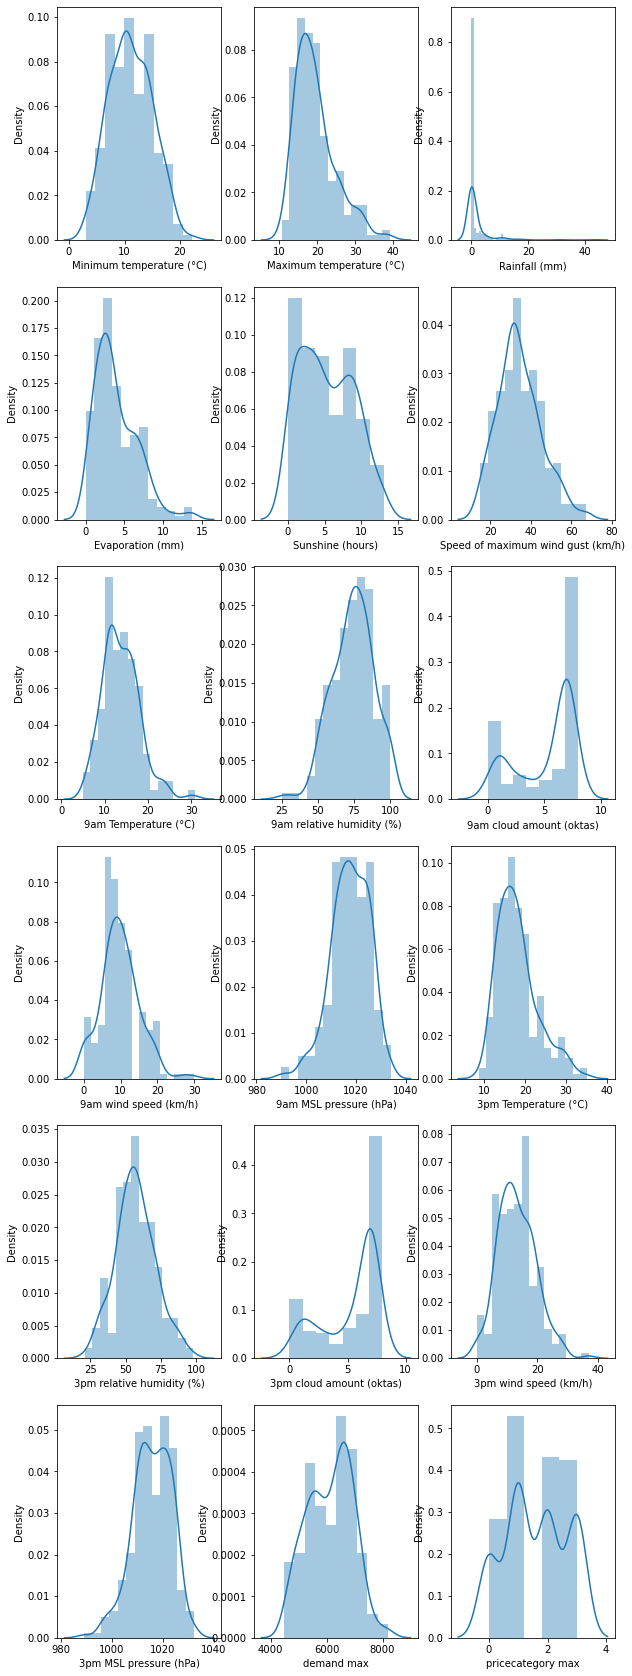

In [20]:
import matplotlib.pyplot as plt
# Define the number of rows and columns you want
n_rows=6
n_cols=3
# Create the subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10, 30))

for i, column in enumerate(df_num.columns):
    sns.distplot(df_num[column],ax=axes[i//n_cols,i%n_cols])
    
plt.show()

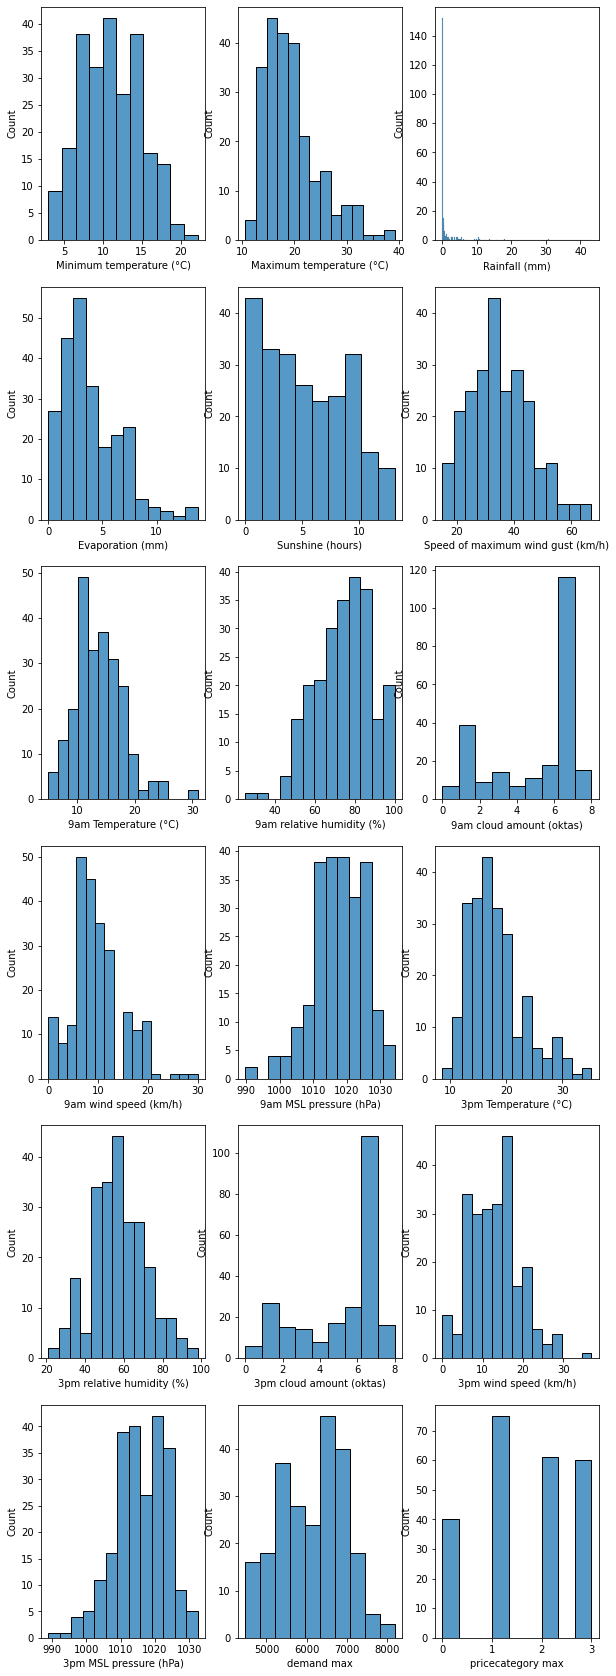

In [21]:
import matplotlib.pyplot as plt
# Define the number of rows and columns you want
n_rows=6
n_cols=3
# Create the subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10, 30))

for i, column in enumerate(df_num.columns):
    sns.histplot(df_num[column],ax=axes[i//n_cols,i%n_cols])

C:\Users\micha\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\micha\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\micha\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

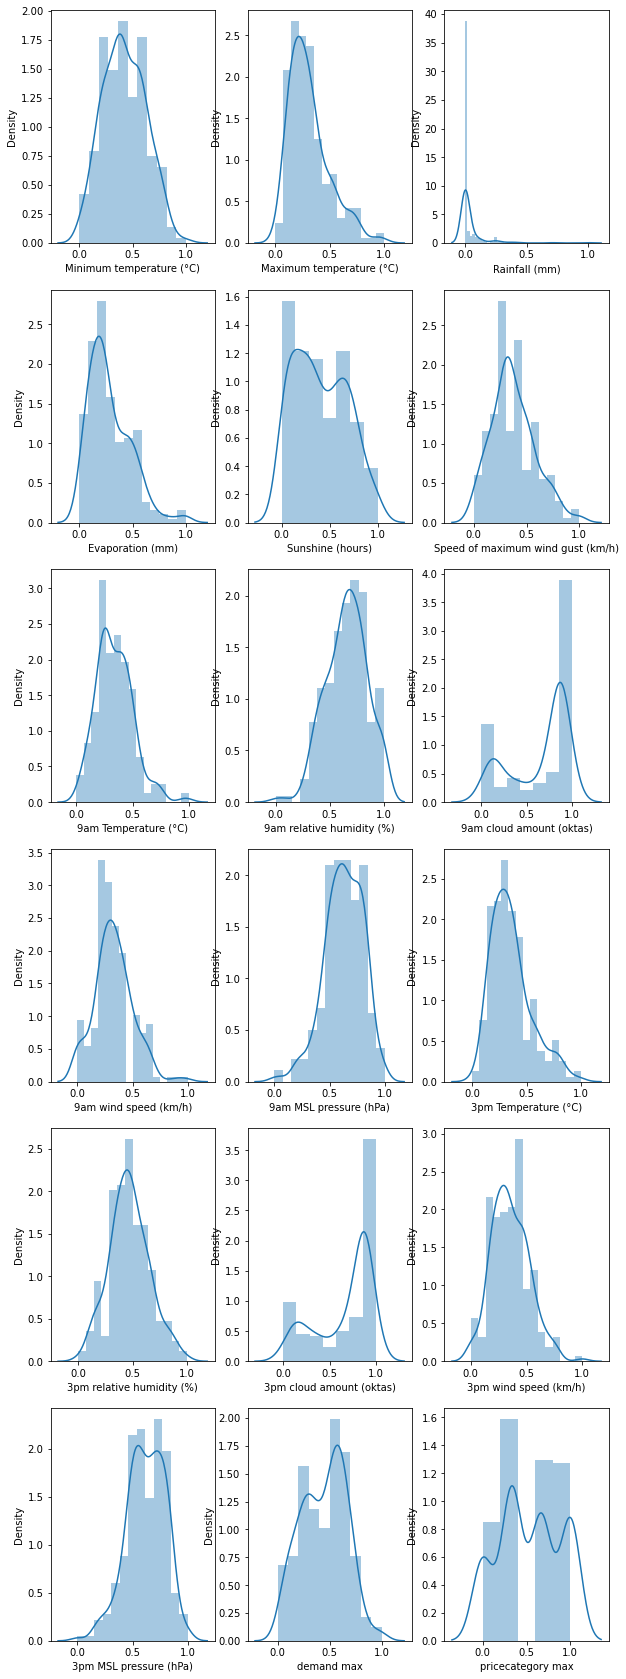

In [22]:
import matplotlib.pyplot as plt
# Define the number of rows and columns you want
n_rows=6
n_cols=3
# Create the subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10, 30))


for i, column in enumerate(df_norm_num.columns):
    sns.distplot(df_norm_num[column],ax=axes[i//n_cols,i%n_cols])

C:\Users\micha\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


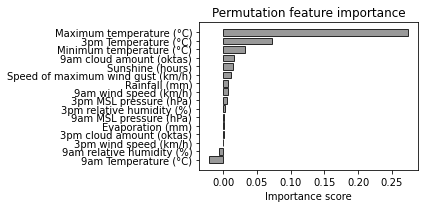

In [23]:
import rfpimp
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

##get just the features
data=df_norm_num[['Minimum temperature (°C)',
             'Maximum temperature (°C)',
             'Rainfall (mm)',
             'Evaporation (mm)',
             'Sunshine (hours)',
             'Speed of maximum wind gust (km/h)',
             '9am Temperature (°C)',
             '9am relative humidity (%)',
             '9am cloud amount (oktas)',
             '9am wind speed (km/h)',
             '9am MSL pressure (hPa)',
             '3pm Temperature (°C)',
             '3pm relative humidity (%)',
             '3pm cloud amount (oktas)',
             '3pm wind speed (km/h)',
             '3pm MSL pressure (hPa)']].astype(float)


##get just the class labels
target = df_norm_num['demand max']

##randomly select 66% of the instances to be training and the rest to be testing
# X_train, X_test, y_train, y_test = train_test_split(df_clean, df_clean_labels, test_size=0.2, random_state=17,shuffle=True)

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=17, shuffle=True)

################################################ Train #############################################

rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=17)
rf.fit(X_train, y_train)

############################### Permutation feature importance #####################################
# random forest importance  ref : https://github.com/parrt/random-forest-importances

imp = rfpimp.importances(rf, X_test, y_test)

############################################## Plot ################################################

fig, ax = plt.subplots(figsize=(6, 3))

ax.barh(imp.index, imp['Importance'], height=0.8, facecolor='grey', alpha=0.8, edgecolor='k')
ax.set_xlabel('Importance score')
ax.set_title('Permutation feature importance')
# ax.text(0.8, 0.15, 'aegis4048.github.io', fontsize=12, ha='center', va='center',
#         transform=ax.transAxes, color='grey', alpha=0.5)
plt.gca().invert_yaxis()

fig.tight_layout()

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np


# regression on single feature
def regression(feature_name, train_data, test_data, train_label, test_label, error='train'):
    
    train_x = train_data[feature_name].values.reshape(-1,1)
    train_y = train_label
    
    test_x = test_data[feature_name].values.reshape(-1,1)
    test_y = test_label.values
    
    # Create linear regression object
    reg_model = LinearRegression() 
    # Train the model using the training sets
    model = reg_model.fit(train_x, train_y)
    
    # R^2
    r2_test = reg_model.score(test_x, test_y)
    r2_train = reg_model.score(train_x, train_y)
    
    
    print('Coefficient of determination (test): {0:.2f}'.format(r2_test))
    print('Coefficient of determination (training): {0:.2f}'.format(r2_train))
    
    print(f'the variations in selected features can explain {r2_test*100}% of the DMAX values in the test set')
    print(f'the variations in selected features can explain {r2_train*100}% of the DMAX values in the train set')

    #the variations in RM and LSTAT can explain 65% of the MEDV values in the training set
    # Make predictions using the train or test
    
    if error == 'train':

        y_pred = model.predict(train_x)
        
        ############################################## Evaluate ############################################        
        mse = mean_squared_error(train_y, y_pred)
        rmse = np.sqrt(mean_squared_error(train_x, y_pred))
    
        # r2 = r2_score(train_y, y_pred)
        # r2 = model.score(train_x, y_pred)

        ############################################## Plot ################################################

        plt.style.use('default')
        plt.style.use('ggplot')

        fig, ax = plt.subplots(figsize=(8, 4))

        ax.plot(train_x, y_pred, color='k', label='Regression model')
        ax.scatter(train_x, train_y, edgecolor='k', facecolor='grey', alpha=0.7, label='Sample data')
        ax.set_ylabel('Max total demand', fontsize=14)
        ax.set_xlabel(feature_name, fontsize=14)

        ax.legend(facecolor='white', fontsize=11)
        ax.set_title(f"Training Error: $MSE= {mse:.2f}$, $RMSE= {rmse:.2f}$, $R^2= {r2_train:.2f}$" , fontsize=18)

        fig.tight_layout()
        
    elif error == 'test':
        
        y_pred = reg_model.predict(test_x)
        
        ############################################## Evaluate ############################################
        # mean sqrt
        mse = mean_squared_error(test_y, y_pred)
        rmse = np.sqrt(mean_squared_error(test_y, y_pred))
        # r2 = model.score(test_x, y_pred)
        # r2 = r2_score(test_y, y_pred)
        
        # coefficients

        print('Coefficients: ', end = ' ')
        print(reg_model.coef_)
        print('')

        # intercept:
        print('Intercept: ', end = ' ')
        print(reg_model.intercept_)
        print('')

        ############################################## Plot ################################################
        
        plt.style.use('default')
        plt.style.use('ggplot')

        fig, ax = plt.subplots(figsize=(8, 4))

        ax.plot(test_x, y_pred, color='k', label='Regression model')
        ax.scatter(test_x, test_y, edgecolor='k', facecolor='grey', alpha=0.7, label='Sample data')
        ax.set_ylabel('Max total demand', fontsize=14)
        ax.set_xlabel(feature_name, fontsize=14)

        ax.legend(facecolor='white', fontsize=11)
        ax.set_title(f"Test: $MSE= {mse:.2f}$, $RMSE= {rmse:.2f}$ , $R^2= {r2_test:.2f}$ " , fontsize=18)

        fig.tight_layout()   
        

In [25]:
features_ordered_by_importance = imp['Importance'].index.tolist()
features_ordered_by_importance

['Maximum temperature (°C)',
 '3pm Temperature (°C)',
 'Minimum temperature (°C)',
 '9am cloud amount (oktas)',
 'Sunshine (hours)',
 'Speed of maximum wind gust (km/h)',
 'Rainfall (mm)',
 '9am wind speed (km/h)',
 '3pm MSL pressure (hPa)',
 '3pm relative humidity (%)',
 '9am MSL pressure (hPa)',
 'Evaporation (mm)',
 '3pm cloud amount (oktas)',
 '3pm wind speed (km/h)',
 '9am relative humidity (%)',
 '9am Temperature (°C)']

selected feature: Maximum temperature (°C)
Coefficient of determination (test): 0.06
Coefficient of determination (training): 0.07
the variations in selected features can explain 6.134744891706035% of the DMAX values in the test set
the variations in selected features can explain 7.428788032434408% of the DMAX values in the train set
Coefficients:  [-0.31728026]

Intercept:  0.5390319175971895

selected feature: 3pm Temperature (°C)
Coefficient of determination (test): 0.03
Coefficient of determination (training): 0.10
the variations in selected features can explain 2.962350252865431% of the DMAX values in the test set
the variations in selected features can explain 10.098642770378508% of the DMAX values in the train set
Coefficients:  [-0.37396662]

Intercept:  0.57376369733556

selected feature: Minimum temperature (°C)
Coefficient of determination (test): 0.18
Coefficient of determination (training): 0.24
the variations in selected features can explain 17.543716682742737% of the DMA

<Figure size 648x432 with 0 Axes>

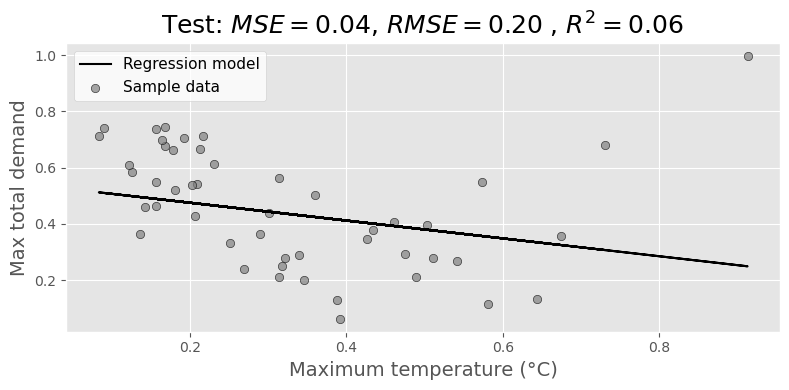

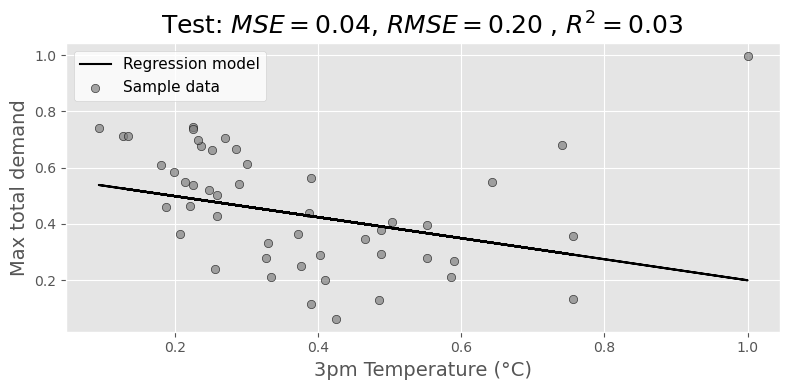

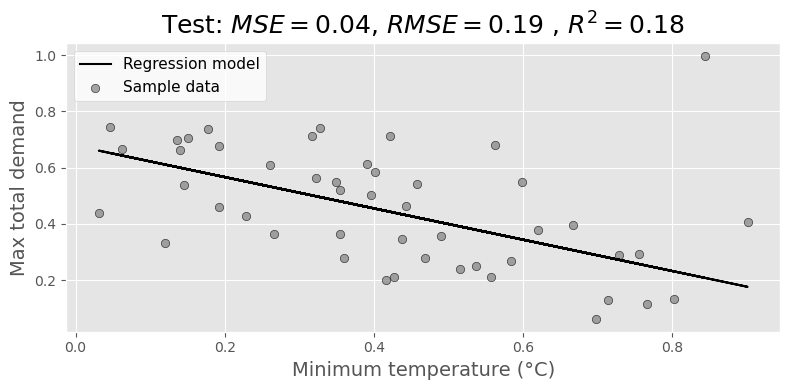

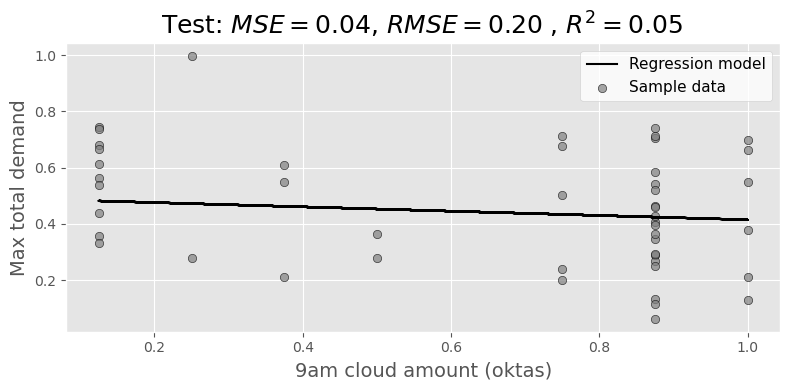

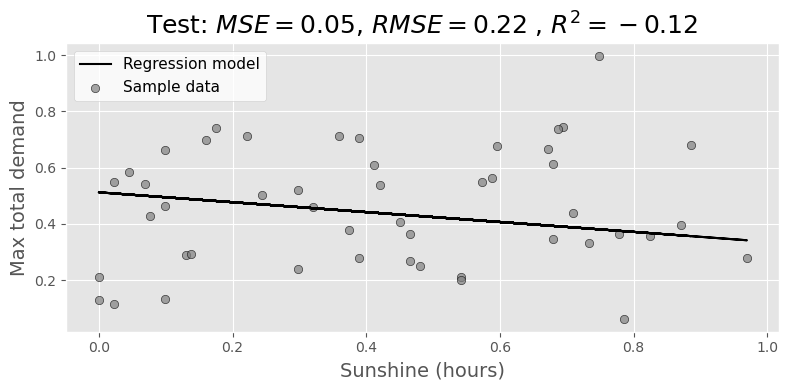

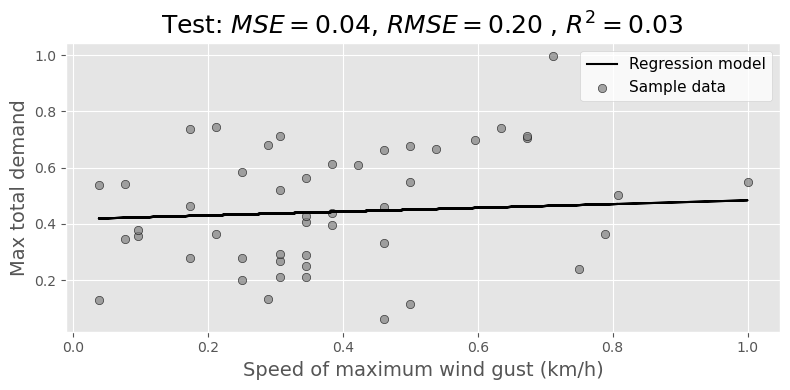

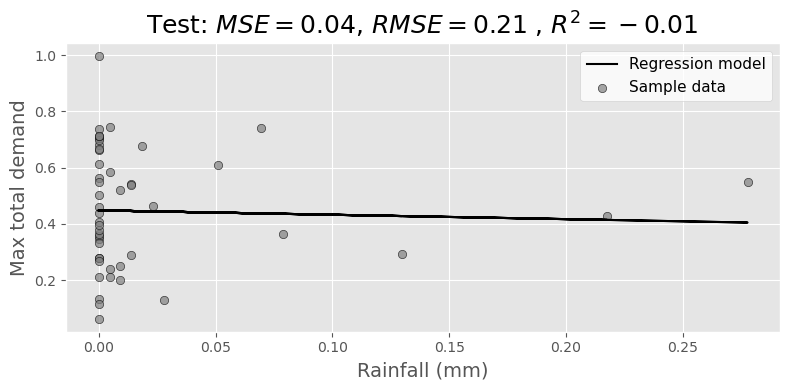

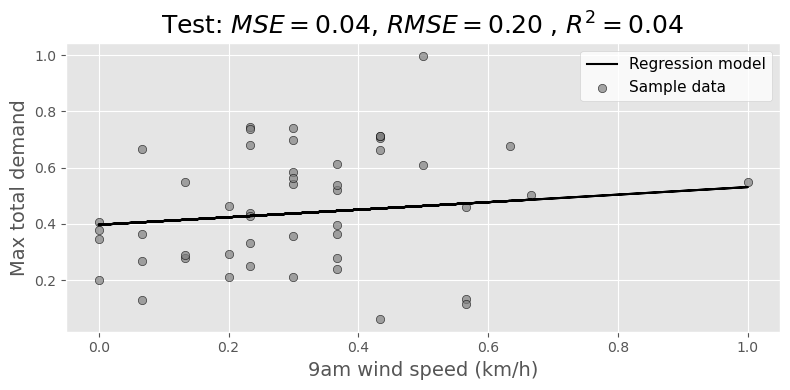

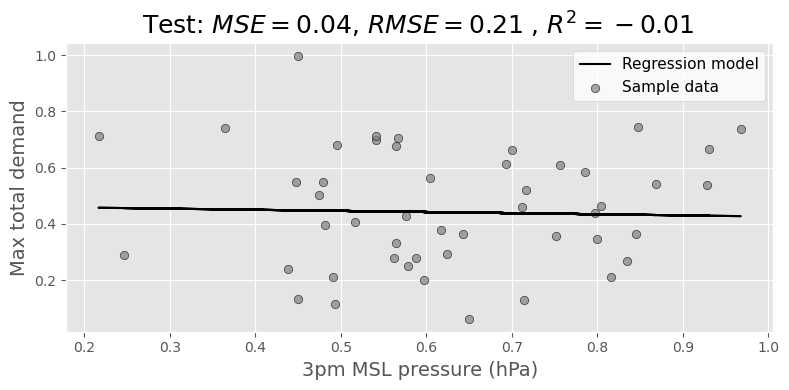

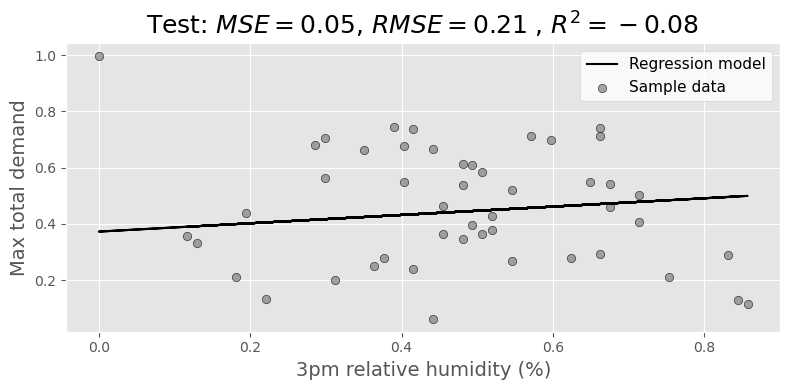

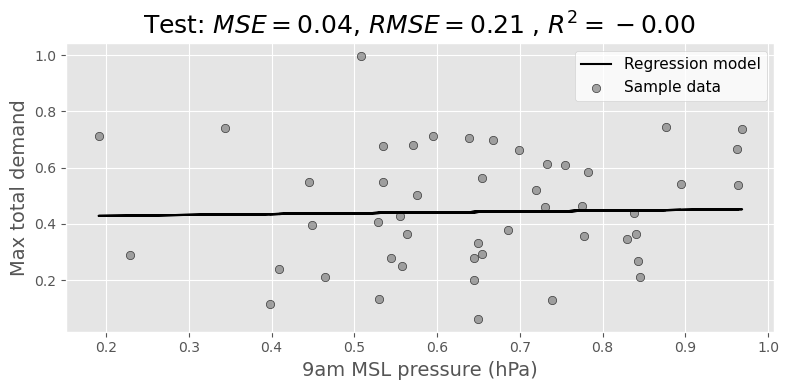

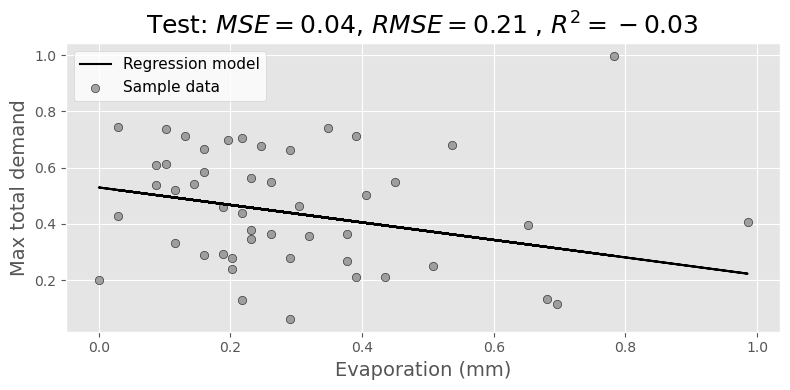

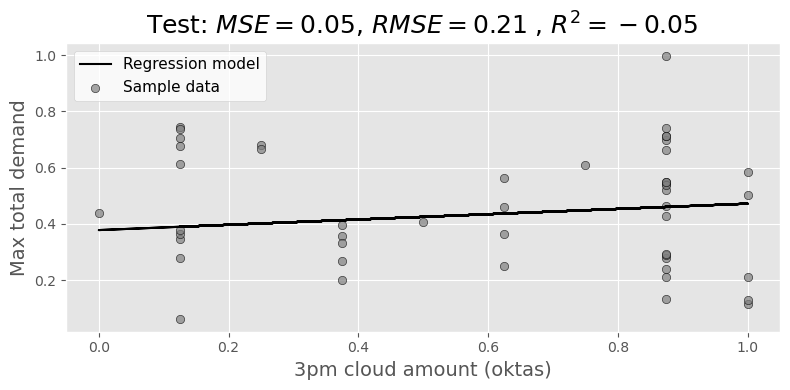

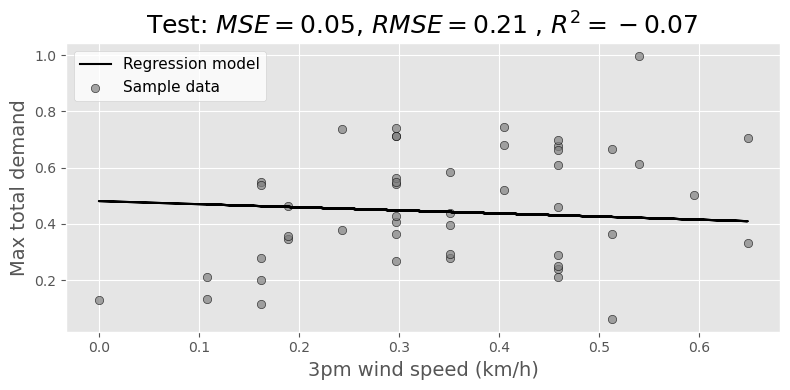

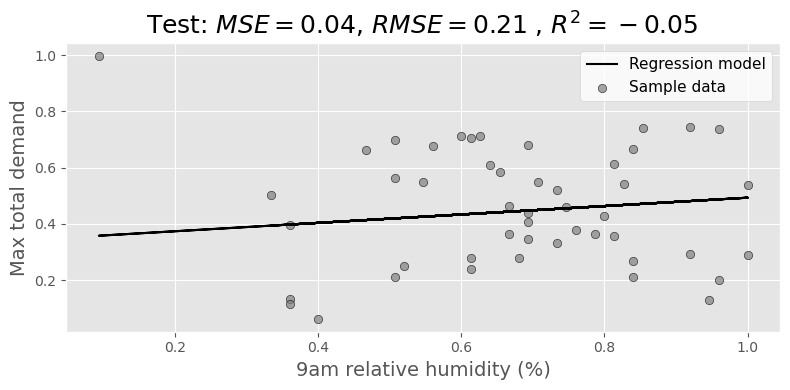

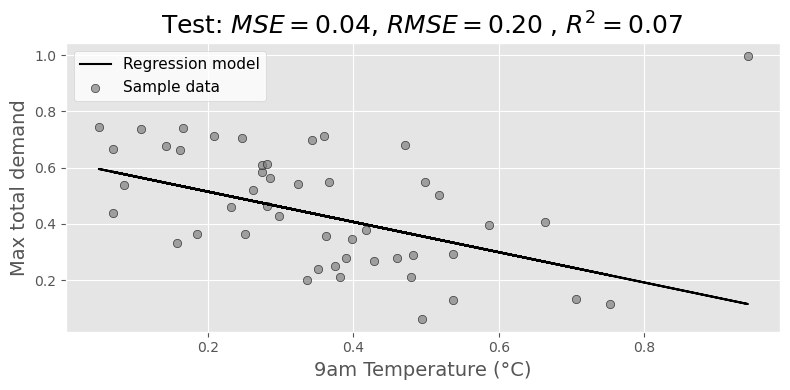

In [26]:
plt.figure(figsize=(9, 6))
for name in features_ordered_by_importance:
    print(f'selected feature: {name}')
    regression(name, X_train,  X_test, y_train, y_test, error='test')
    

In [27]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


##get just the features
data=df_norm_num[['Maximum temperature (°C)','3pm Temperature (°C)']].astype(float)


##get just the class labels
target = df_norm_num['demand max']
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)


# partial code here...
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
y_test_predictions = lm.predict(X_test)

# coefficients
print('Coefficients: ', end = ' ')
print(lm.coef_)
print('')

# intercept:
print('Intercept: ', end = ' ')
print(lm.intercept_)
print('')

# R^2
r2_test = lm.score(X_test, y_test)
r2_train = lm.score(X_train, y_train)

print('Coefficient of determination (test): {0:.2f}'.format(r2_test))
print('Coefficient of determination (training): {0:.2f}'.format(r2_train))
print(f'the variations in selected features can explain {np.abs(r2_test*100)}% of the DMAX values in the test set')


Coefficients:  [ 0.66918973 -1.05179672]

Intercept:  0.6079361643922434

Coefficient of determination (test): -0.13
Coefficient of determination (training): 0.14
the variations in selected features can explain 13.257267389375137% of the DMAX values in the test set


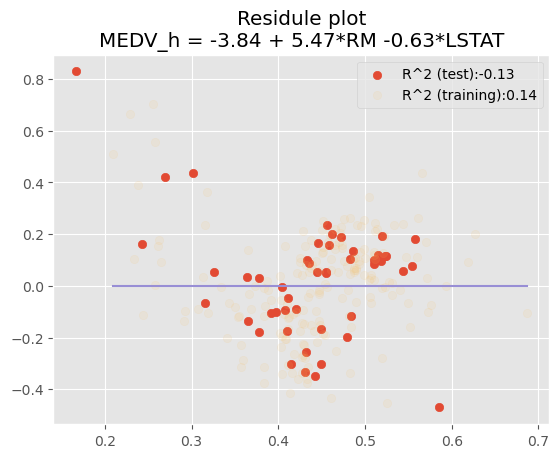

In [28]:
import matplotlib.pyplot as plt
# Plot residules

m = 'MEDV_h = -3.84 + 5.47*RM -0.63*LSTAT'
y_test_h = lm.predict(X_test)
y_train_h = lm.predict(X_train)

residual_train = [y - yh for y, yh in zip(y_train, y_train_h)]
residual_test = [y - yh for y, yh in zip(y_test, y_test_h)]

plt.scatter(y_test_h, residual_test, color='C0', label = 'R^2 (test):{0:.2f}'.format(r2_test))
plt.scatter(y_train_h, residual_train, color='C4', alpha = 0.1, label = 'R^2 (training):{0:.2f}'.format(r2_train))
plt.plot([min(y_train_h), max(y_train_h)], [0,0], color= 'C2')
plt.legend()
plt.title("Residule plot\n{}".format(m))
plt.show()


## Decision Tree

Decision tree was initially explored as a possible classifier for predicting price category. Ultimately the decision was to focus on the KNN classifier. This code has been left to review. 

0.45625 {'max_depth': 14}
Best Score:  0.45625
Parameters:  {'max_depth': 14}
Average score:  0.4306184012066365
Average std:  0.11723084846864906


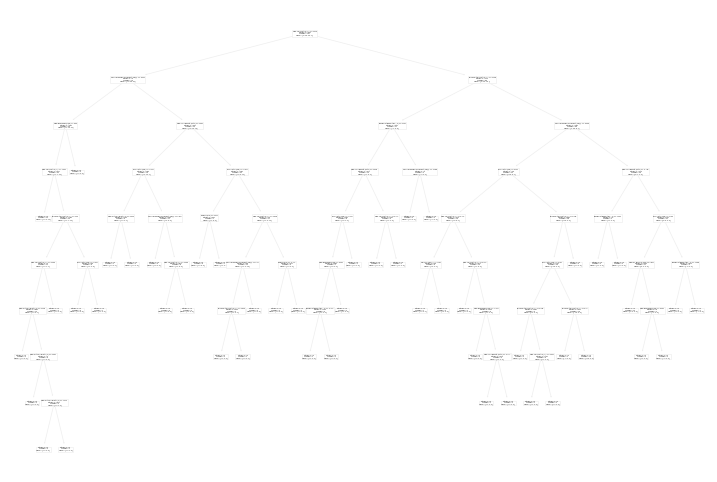

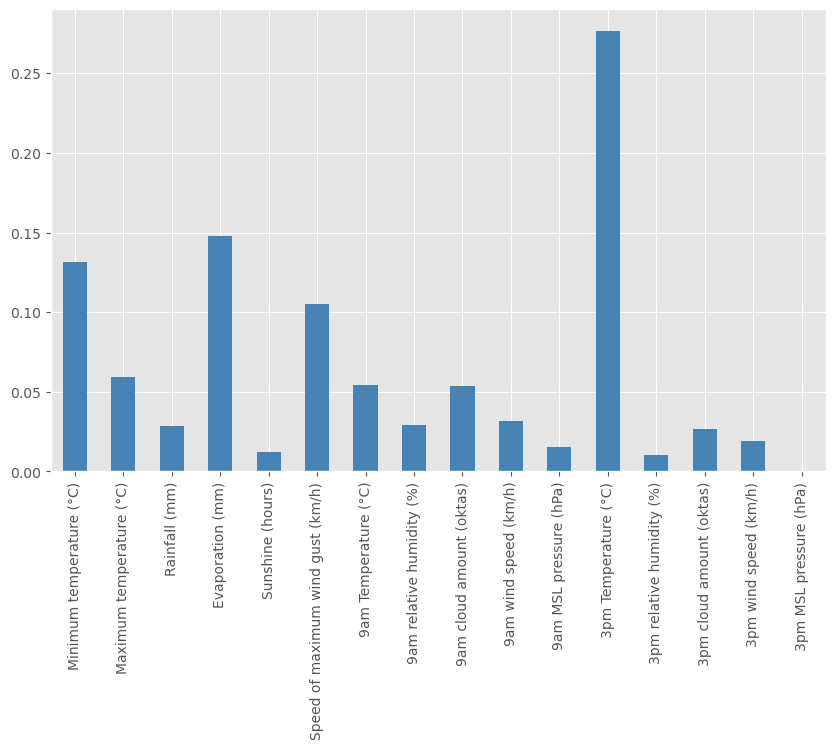

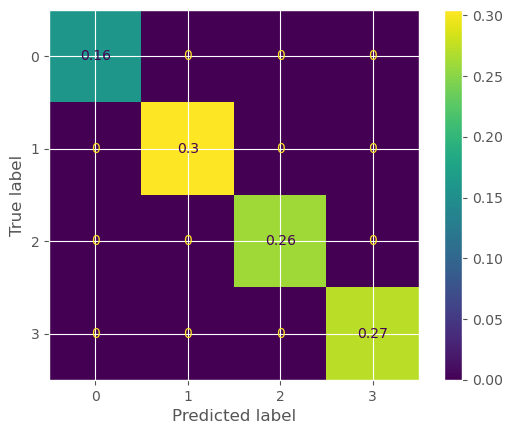

In [29]:

features_dt = all_data[['Minimum temperature (°C)',
             'Maximum temperature (°C)',
             'Rainfall (mm)',
             'Evaporation (mm)',
             'Sunshine (hours)',
             'Speed of maximum wind gust (km/h)',
             '9am Temperature (°C)',
             '9am relative humidity (%)',
             '9am cloud amount (oktas)',
             '9am wind speed (km/h)',
             '9am MSL pressure (hPa)',
             '3pm Temperature (°C)',
             '3pm relative humidity (%)',
             '3pm cloud amount (oktas)',
             '3pm wind speed (km/h)',
             '3pm MSL pressure (hPa)']].astype(float)

classlabel = all_data['pricecategory max']

features_train, features_test, class_train, class_test = train_test_split(features_dt, classlabel, train_size=0.7, test_size=0.3, random_state=5)

# Scale features
scaler = preprocessing.StandardScaler().fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

# imputer missing values via imputation
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
features_train = imp.fit_transform(features_train)
test_train = imp.fit_transform(features_test)

# remove outliers from training set
lof = LocalOutlierFactor()
yhat = lof.fit_predict(features_train)
mask = yhat != -1
features_train, class_train = features_train[mask, :], class_train[mask]

# cross validation to find best parameter
parameters = {'max_depth':range(2, 15)}

# Cross validation for method - used RepeatedStratifiedKFold due to small data set
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats=3, random_state=42)

clf = GridSearchCV(DecisionTreeClassifier(criterion='entropy'), parameters, cv = cv)
clf.fit(features_train, class_train)

# model is the estimator with best accurac
print(clf.best_score_, clf.best_params_)
model = clf.best_estimator_

# model is the estimator with best accuracy from the grid search. Outputs accuracy and parameters 
print("Best Score: ", clf.best_score_)
print("Parameters: ", clf.best_params_)
print("Average score: ", sum(clf.cv_results_['mean_test_score']) / len(clf.cv_results_['mean_test_score']))
avg_std = (sum(clf.cv_results_['std_test_score']) / len(clf.cv_results_['std_test_score']))
print('Average std: ', avg_std)

plt.figure(figsize=(9 , 6))
tree.plot_tree(model, feature_names=features_dt.columns)
plt.show()

pd.Series(model.feature_importances_, index = features_dt.columns).plot.bar(color='steelblue', figsize=(10, 6))
plt.show()

plot_confusion_matrix(clf, features_train, class_train, normalize='all')
plt.show()

### KNN

Best Score:  0.5052631578947367
Parameters:  {'n_neighbors': 11}
Average score:  0.4486246480398527
Average std:  0.08874963525778949
Metric Used:  euclidean


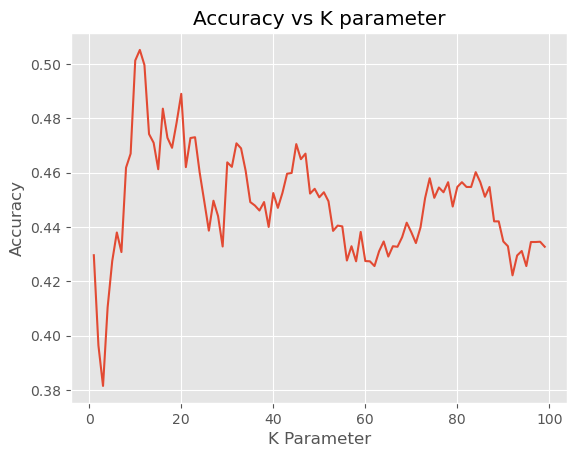

Model Accuracy on test data:  0.5625


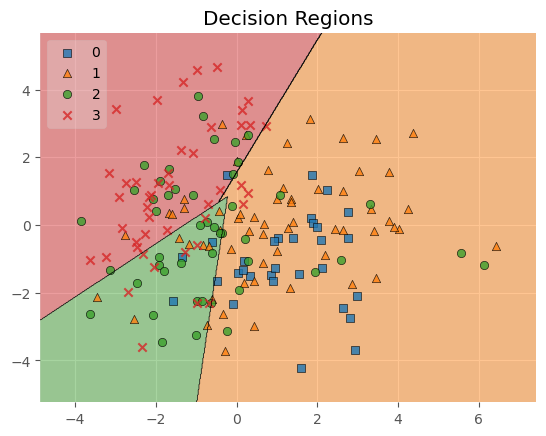

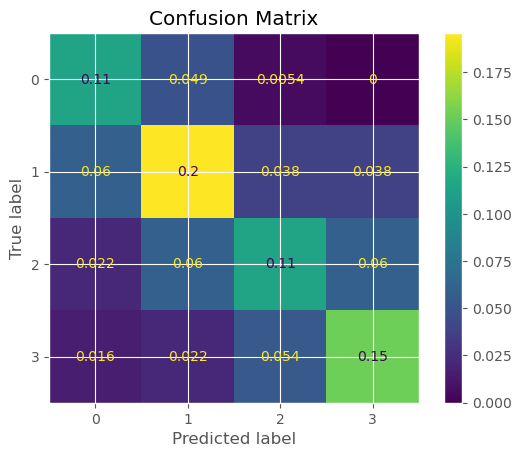

In [30]:
features_knn = all_data[['Minimum temperature (°C)',
             'Maximum temperature (°C)',
             'Rainfall (mm)',
             'Evaporation (mm)',
             'Sunshine (hours)',
             'Speed of maximum wind gust (km/h)',
             '9am Temperature (°C)',
             '9am relative humidity (%)',
             '9am cloud amount (oktas)',
             '9am wind speed (km/h)',
             '9am MSL pressure (hPa)',
             '3pm Temperature (°C)',
             '3pm relative humidity (%)',
             '3pm cloud amount (oktas)',
             '3pm wind speed (km/h)',
             '3pm MSL pressure (hPa)']].astype(float)

# price category max as class label
classlabel = all_data['pricecategory max']

# Splits the data in to training and test set - will build on this to explore if split improves model
features_train, features_test, class_train, class_test = train_test_split(features_knn, classlabel, train_size=0.80, test_size=0.20)

# Scale features to reduce distance between low and large weighted data
scaler = preprocessing.StandardScaler().fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

# # imputer missing values via imputation (use mean to impute data)
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
features_train = imp.fit_transform(features_train)
features_test = imp.fit_transform(features_test)

# remove outliers from training set
lof = LocalOutlierFactor()
yhat = lof.fit_predict(features_train)
mask = yhat != -1
features_train, class_train = features_train[mask, :], class_train[mask]

# range for value K to tune in model
ks = range(1,100)

# parameters to be tuned in cross validation - can explore these further
parameters = [{'n_neighbors': ks}]

# Cross validation for method - used RepeatedStratifiedKFold due to small data set
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats=3, random_state=42)

# GridSearchCV sets up grid search to search for best paramters, uses 10 KFolds
clf = GridSearchCV(neighbors.KNeighborsClassifier(), parameters, cv = cv)
clf.fit(features_train, class_train)

# model is the estimator with best accuracy from the grid search. Outputs accuracy and parameters 
print("Best Score: ", clf.best_score_)
print("Parameters: ", clf.best_params_)
print("Average score: ", sum(clf.cv_results_['mean_test_score']) / len(clf.cv_results_['mean_test_score']))
avg_std = (sum(clf.cv_results_['std_test_score']) / len(clf.cv_results_['std_test_score']))
print('Average std: ', avg_std)
print('Metric Used: ', clf.best_estimator_.effective_metric_)

# Plot k value vs accuracy
plt.plot(ks, clf.cv_results_['mean_test_score'])
plt.title('Accuracy vs K parameter')
plt.xlabel('K Parameter')
plt.ylabel('Accuracy')
plt.show()

# set best k value from cross validation and create and train new model to test
best_k = clf.best_params_['n_neighbors']
knn = neighbors.KNeighborsClassifier(n_neighbors=best_k)
knn.fit(features_train, class_train)
predic = knn.predict(features_test)
test_accuracy = accuracy_score(class_test, predic)
print('Model Accuracy on test data: ', test_accuracy)

# PCA to reduce deminsionality to plot feature space to show decision regions
clf2 = svm.SVC(C=100,gamma=0.0001)
pca = PCA(n_components = 2)
X_train2 = pca.fit_transform(features_train)
clf2.fit(X_train2, class_train)
plot_decision_regions(X_train2, class_train.values, clf=clf2, legend=2)
plt.title('Decision Regions')
plt.show()

# Plot confusion matrix to model with tuned parameters performed
plot_confusion_matrix(clf, features_train, class_train, normalize='all')
plt.title('Confusion Matrix')
plt.show()

